# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [4]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


There are 17000 different users


Text(0, 0.5, '')

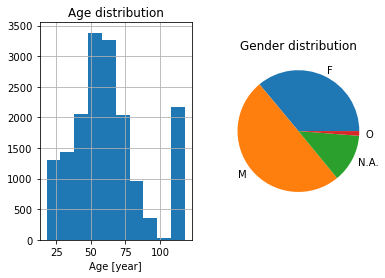

In [8]:
print(f"There are {len(set(profile['id']))} different users")
plt.figure()

plt.subplot(121)
ax = profile.age.hist()
ax.set_xlabel('Age [year]')
plt.title('Age distribution')

plt.subplot(122)
ax = profile.fillna('N.A.').groupby('gender').count()['age'].plot.pie()
plt.title('Gender distribution')
ax.set_ylabel('')

In [9]:
transcript.loc[transcript['event']=='offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript.loc[transcript['event']=='offer viewed'].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [11]:
transcript.loc[transcript['event']=='offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [12]:
transcript.loc[transcript['event']=='offer completed'].iloc[0]['value']

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [13]:
transcript.loc[transcript['event']=='transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


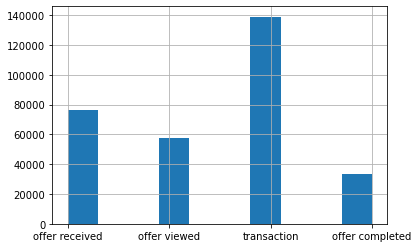

In [14]:
transcript.event.hist()

In [15]:
transcript.shape

(306534, 4)

In [16]:
# Analyzie a bit offers
t = transcript[['person', 'event']]
t = t.join(pd.get_dummies(t['event']))
t2 = t.groupby('person').sum()
t2.head()

,offer completed,offer received,offer viewed,transaction
person,,,,
0009655768c64bdeb2e877511632db8f,3,5,4,8
00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
0020c2b971eb4e9188eac86d93036a77,3,5,3,8
0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12


In [17]:
assert (t2['offer received']<t2['offer completed']).sum() == 0
assert (t2['offer received']<t2['offer viewed']).sum() == 0


In [18]:
# Offer completed, but not viewed!
t2.loc[(t2['offer viewed']<t2['offer completed'])]

,offer completed,offer received,offer viewed,transaction
person,,,,
004c5799adbf42868b9cff0396190900,5,5,4,12
00715b6e55c3431cb56ff7307eb19675,5,6,3,15
00840a2ca5d2408e982d56544dc14ffd,3,6,2,17
00b3400e4ff64ee68ce9ada1d0c222f0,3,5,2,10
00b3c376db2a4115af3aef34a02f61d6,3,3,2,8
...,...,...,...,...
ffa81afacde642a3a51a7cd99f8d2cd7,4,5,2,10
ffd53e5ba61d41378b66efc00d9f9682,5,5,2,12
ffdefcac307f4ca99ac1ebd51470f106,5,5,2,8


# Data Cleaning
Cleaning of the dataframes

In [42]:
# Converting channels in specific dummy column 
portfolio = portfolio.join(pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0))
portfolio.set_index('id', inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,email,mobile,social,web
id,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,1,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational,1,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,1,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,1,0,0,1


In [20]:
# Convert become_member_on in datetime
profile['became_member_on_date'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income,became_member_on_date
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04


In [21]:
# Extract offer value information
transcript = transcript.join(transcript['value'].apply(pd.Series))
transcript['offer_id'] = transcript.offer_id.combine_first(transcript['offer id'])
transcript.drop(columns='offer id', inplace=True)
transcript.head()

,person,event,value,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Try parse transcript all together: I don't think it works

In [22]:
# Put on 1 line offers
offer = transcript.loc[transcript.event == 'offer received',['person','time','offer_id']].set_index(['person','offer_id'])
offer = offer.join(transcript.loc[transcript.event == 'offer viewed',['person','time','offer_id']].
                   set_index(['person','offer_id']), how='left', lsuffix='_received', rsuffix='_viewed')
offer = offer.join(transcript.loc[transcript.event == 'offer completed',['person','time','offer_id','reward']].
                   set_index(['person','offer_id']), how='left')
offer = offer.rename(columns={'time': 'time_completed', 'reward': 'reward_completed'})
offer.head()

time_received  \
person                           offer_id                                          
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5            576   
                                 3f207df678b143eea3cee63160fa8bed            336   
                                 5a8bc65990b245e5a138643cd4eb9837            168   
                                 f19421c1d4aa40978ebb69ca19b0e20d            408   
                                 fafdcd668e3743c1bb461111dcafc2a4            504   

                                                                   time_viewed  \
person                           offer_id                                        
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5          NaN   
                                 3f207df678b143eea3cee63160fa8bed        372.0   
                                 5a8bc65990b245e5a138643cd4eb9837        192.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d        456.0   
                                 fafdcd668e3743c1bb461111dcafc2a4        540.0   

                                                                   time_completed  \
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5           576.0   
                                 3f207df678b143eea3cee63160fa8bed             NaN   
                                 5a8bc65990b245e5a138643cd4eb9837             NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d           414.0   
                                 fafdcd668e3743c1bb461111dcafc2a4           528.0   

                                                                   reward_completed  
person                           offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5               2.0  
                                 3f207df678b143eea3cee63160fa8bed               NaN  
                                 5a8bc65990b245e5a138643cd4eb9837               NaN  
                                 f19421c1d4aa40978ebb69ca19b0e20d               5.0  
                                 fafdcd668e3743c1bb461111dcafc2a4               2.0

In [23]:
transaction = transcript.loc[transcript.event == 'transaction',['person','time','amount']]
transaction.head()

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [33]:
offer.loc[(offer['time_received'] > offer['time_viewed'])]

time_received  \
person                           offer_id                                          
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d            576   
0020c2b971eb4e9188eac86d93036a77 fafdcd668e3743c1bb461111dcafc2a4            336   
                                 fafdcd668e3743c1bb461111dcafc2a4            336   
003d66b6608740288d6cc97a6903f4f0 fafdcd668e3743c1bb461111dcafc2a4            408   
                                 fafdcd668e3743c1bb461111dcafc2a4            408   
...                                                                          ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5            576   
                                 2906b810c7d4411798c6938adc9daaa5            576   
                                 2906b810c7d4411798c6938adc9daaa5            576   
                                 2906b810c7d4411798c6938adc9daaa5            576   
                                 2906b810c7d4411798c6938adc9daaa5            576   

                                                                   time_viewed  \
person                           offer_id                                        
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d        216.0   
0020c2b971eb4e9188eac86d93036a77 fafdcd668e3743c1bb461111dcafc2a4         12.0   
                                 fafdcd668e3743c1bb461111dcafc2a4         12.0   
003d66b6608740288d6cc97a6903f4f0 fafdcd668e3743c1bb461111dcafc2a4        300.0   
                                 fafdcd668e3743c1bb461111dcafc2a4        300.0   
...                                                                        ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5        354.0   
                                 2906b810c7d4411798c6938adc9daaa5        354.0   
                                 2906b810c7d4411798c6938adc9daaa5        414.0   
                                 2906b810c7d4411798c6938adc9daaa5        414.0   
                                 2906b810c7d4411798c6938adc9daaa5        414.0   

                                                                   time_completed  \
person                           offer_id                                           
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d             NaN   
0020c2b971eb4e9188eac86d93036a77 fafdcd668e3743c1bb461111dcafc2a4            54.0   
                                 fafdcd668e3743c1bb461111dcafc2a4           510.0   
003d66b6608740288d6cc97a6903f4f0 fafdcd668e3743c1bb461111dcafc2a4           384.0   
                                 fafdcd668e3743c1bb461111dcafc2a4           504.0   
...                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5           414.0   
                                 2906b810c7d4411798c6938adc9daaa5           576.0   
                                 2906b810c7d4411798c6938adc9daaa5           384.0   
                                 2906b810c7d4411798c6938adc9daaa5           414.0   
                                 2906b810c7d4411798c6938adc9daaa5           576.0   

                                                                   reward_completed  
person                           offer_id                                            
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d               NaN  
0020c2b971eb4e9188eac86d93036a77 fafdcd668e3743c1bb461111dcafc2a4               2.0  
                                 fafdcd668e3743c1bb461111dcafc2a4               2.0  
003d66b6608740288d6cc97a6903f4f0 fafdcd668e3743c1bb461111dcafc2a4               2.0  
                                 fafdcd668e3743c1bb461111dcafc2a4               2.0  
...                                                                             ...  
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5               2.0  
                           

In [34]:
transcript.loc[transcript['person']=='00116118485d4dfda04fdbaba9a87b5c']

,person,event,value,time,amount,offer_id,reward
56475,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
85769,00116118485d4dfda04fdbaba9a87b5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},216,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
104088,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 0.7000000000000001},294,0.70,NaN,NaN
187632,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 0.2},456,0.20,NaN,NaN
193680,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 3.19},474,3.19,NaN,NaN
248359,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
284472,00116118485d4dfda04fdbaba9a87b5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},630,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN


Try parsing consequentially

In [95]:
list_person = list(transcript['person'].unique())
offer2 = transcript.loc[transcript.event.isin(['offer received','offer viewed','offer completed']), 
                       ['person','event','time','offer_id','reward']]
offer2 = offer2.merge(portfolio[['duration']].reset_index(), left_on=['offer_id'], right_on=['id'], how='left')

In [96]:
offer2

,person,event,time,offer_id,reward,id,duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,10
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,7
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,10
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,5
...,...,...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,7
167577,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.0,fafdcd668e3743c1bb461111dcafc2a4,10
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,10
167579,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.0,fafdcd668e3743c1bb461111dcafc2a4,10


In [150]:
# Create the cleaned dataframe
offer_cleaned_cols = ['time_received','time_viewed','time_completed','reward']
offer_cleaned_ids = pd.MultiIndex(levels=[[],[]], codes=[[],[]],names=['person','offer_id'])
offer_cleaned = pd.DataFrame(columns=offer_cleaned_cols, 
                             index=offer_cleaned_ids)

# Parse offers!
for idx in offer2.index:
    tmp = offer2.loc[idx]
    if tmp['event'] == 'offer received':
        if tmp[['person','offer_id']].values not in offer_cleaned.index.values:
            # The line is new
            offer_cleaned.loc[tuple(tmp[['person','offer_id']]),:] = [tmp['time'],None,None,None]
        else:
            print('yeah')
            offer_cleaned.append(pd.DataFrame([tmp['time'],None,None,None], columns=offer_cleaned_cols, 
                             index=offer_cleaned_ids))
    
    if idx == 10000:
        break

offer_cleaned

<ipython-input-150-5af3ad53431e>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tmp[['person','offer_id']].values not in offer_cleaned.index.values:


,,time_received,time_viewed,time_completed,reward
person,offer_id,,,,
78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,None,None,None
a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,None,None,None
e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,None,None,None
8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,None,None,None
68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,None,None,None
...,...,...,...,...,...
f4bc91d5a549410d8f98a2461dc24baa,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,None,None,None
5dd229138aca45f29ee9d6d4417f199a,2298d6c36e964ae4a3e7e9706d1fb8c2,0,None,None,None
e431ebcc6f944c5c9a2d93cbd4a790d7,4d5c57ea9a6940dd891ad53e9dbe8da0,0,None,None,None


In [151]:
offer_cleaned['time_received'].sum()

0

In [152]:
# sto processando in ordine, perchè non funziona con le righe duplicate

In [24]:
transaction.loc[transaction.person=='0009655768c64bdeb2e877511632db8f']

,person,time,amount
89291,0009655768c64bdeb2e877511632db8f,228,22.16
168412,0009655768c64bdeb2e877511632db8f,414,8.57
228422,0009655768c64bdeb2e877511632db8f,528,14.11
237784,0009655768c64bdeb2e877511632db8f,552,13.56
258883,0009655768c64bdeb2e877511632db8f,576,10.27
293497,0009655768c64bdeb2e877511632db8f,660,12.36
300930,0009655768c64bdeb2e877511632db8f,690,28.16
302205,0009655768c64bdeb2e877511632db8f,696,18.41


In [25]:
offer.loc['0009655768c64bdeb2e877511632db8f']

,time_received,time_viewed,time_completed,reward_completed
offer_id,,,,
2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0
3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,NaN
5a8bc65990b245e5a138643cd4eb9837,168,192.0,NaN,NaN
f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,5.0
fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,2.0


In [26]:
transcript.loc[transcript.person=='0009655768c64bdeb2e877511632db8f']

,person,event,value,time,amount,offer_id,reward
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,NaN
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
168412,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414,8.57,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
187554,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
204340,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN


In [27]:
# Devo controllare se un'offerta viene vista dopo essere stata completata

# Devo capire cosa significa il tempo